In [14]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'delivery'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
]

# Connect to MySQL (without specifying a database initially)
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root'
)
cursor = conn.cursor()

# 🔹 **Check if 'ecommerce' database exists**
cursor.execute("SHOW DATABASES")
databases = [db[0] for db in cursor.fetchall()]

if 'ecommerce' in databases:
    print("Database 'ecommerce' exists. Dropping it...")
    cursor.execute("DROP DATABASE ecommerce")

# 🔹 **Create a fresh 'ecommerce' database**
cursor.execute("CREATE DATABASE ecommerce")
print("Database 'ecommerce' created successfully!")

# Close and reconnect to the newly created database
conn.close()
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'D:\Projects\Data Analysis\Project 2\archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()



Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [9]:
import matplotlib.pyplot as plt
import mysql.connector
import pandas as pd
import os
import seaborn as sns

In [10]:
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='ecommerce'
)
cursor = conn.cursor()

# 1. List all unique cities where customers are located.

In [14]:
querry = """ select distinct customer_city from customers """
cursor.execute(querry)
data = cursor.fetchall()
data[:10]

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',)]

# 2. Count the number of orders placed in 2017.

In [26]:
querry = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cursor.execute(querry)
data = cursor.fetchall()
'Total orders placed in 2017 is', data[0][0]

('Total orders placed in 2017 is', 45101)

# 3. Find the total sales per category.

In [16]:
querry = """ select products.product_category category, round(sum(payments.payment_value),2) sales
from products join order_items on products.product_id = order_items.product_id
join payments on payments.order_id = order_items.order_id
group by category """
cursor.execute(querry)
data = cursor.fetchall()
data

[('perfumery', 506738.66),
 ('Furniture Decoration', 1430176.39),
 ('telephony', 486882.05),
 ('bed table bath', 1712553.67),
 ('automotive', 852294.33),
 ('computer accessories', 1585330.45),
 ('housewares', 1094758.13),
 ('babies', 539845.66),
 ('toys', 619037.69),
 ('Furniture office', 646826.49),
 ('Cool Stuff', 779698.0),
 ('HEALTH BEAUTY', 1657373.12),
 ('pet Shop', 311268.97),
 ('General Interest Books', 64694.76),
 ('stationary store', 317440.07),
 ('Watches present', 1429216.68),
 ('PCs', 279121.55),
 ('climatization', 91170.66),
 ('Construction Tools Construction', 241475.63),
 ('sport leisure', 1392127.56),
 ('Bags Accessories', 187151.29),
 ('electronics', 259857.1),
 ('Casa Construcao', 136645.29),
 ('Games consoles', 195480.38),
 ('Fashion Bags and Accessories', 218158.28),
 ('home appliances', 95532.27),
 ('Garden tools', 838280.75),
 ('Agro Industria e Comercio', 118730.61),
 (None, 252801.71),
 ('audio', 60324.62),
 ('technical books', 24915.44),
 ('Construction Tools 

# 4. Calculate the percentage of orders that were paid in installments.

In [3]:
querry = """ select (sum(case when payment_installments >= 1 then 1
else 0 end))*100/count(*) 
from payments"""
cursor.execute(querry)
data = cursor.fetchall()
'Percentage of orders that were pain in installments is ', data[0][0]

('Percentage of orders that were pain in installments is ', Decimal('99.9981'))

# 5. Count the number of customers from each state. 

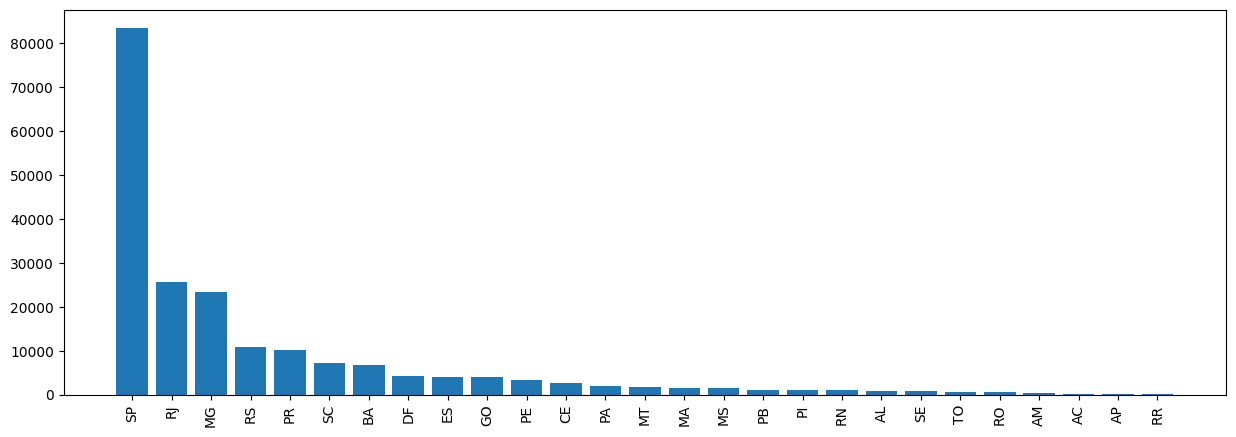

In [13]:
querry = """ select customer_state state, count(customer_id) from customers group by state """
cursor.execute(querry)
data = cursor.fetchall()
df = pd.DataFrame(data, columns= ['States','Number of Customers'])
df = df.sort_values(by= 'Number of Customers', ascending= False)

plt.figure(figsize= (15,5))
plt.bar(df['States'], df['Number of Customers'])
plt.xticks(rotation = 90)
plt.show()

# 6. Calculate the number of orders per month in 2018.

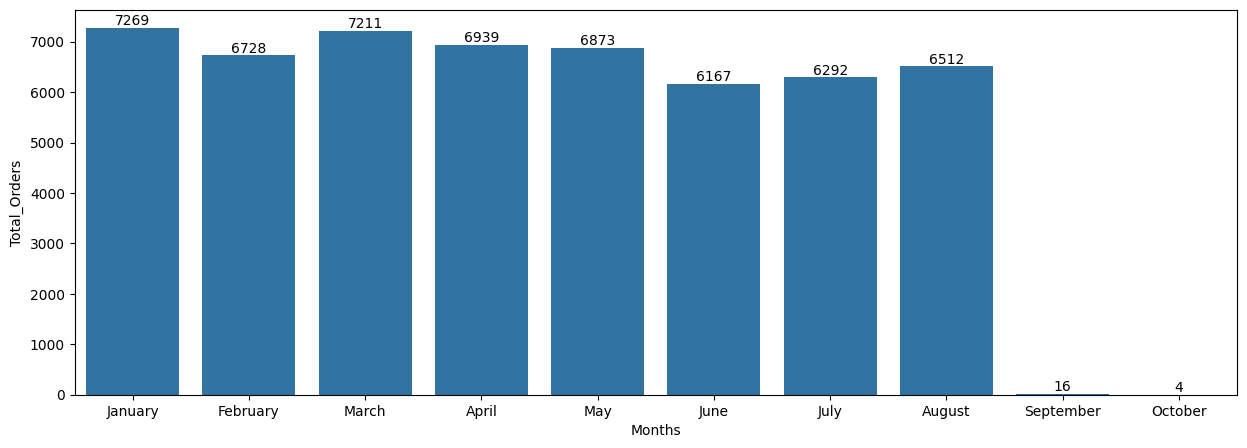

In [16]:
querry = """ select monthname(order_purchase_timestamp) Months, count(order_id) Total_Orders
from orders 
where year(order_purchase_timestamp) = 2018
GROUP BY MONTH(order_purchase_timestamp), MONTHNAME(order_purchase_timestamp)
ORDER BY MONTH(order_purchase_timestamp)"""
cursor.execute(querry)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["Months", "Total_Orders"])

plt.figure(figsize=(15,5))
ax = sns.barplot(x="Months", y="Total_Orders", data=df)
ax.bar_label(ax.containers[0])
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [19]:
querry = """ with count_per_order as (
select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, avg(count_per_order.oc)
from customers join count_per_order 
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
"""
cursor.execute(querry)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=('City', 'Average Order per Customer'))
df


,City,Average Order per Customer
0,sao paulo,1.1562
1,sao jose dos campos,1.1385
2,porto alegre,1.1749
3,indaial,1.1154
4,treze tilias,1.2727
...,...,...
4105,japaratuba,1.0000
4106,sebastiao leal,1.0000
4107,buriti,3.0000
4108,morro agudo de goias,1.0000


# 8. Calculate the percentage of total revenue contributed by each product category.

In [24]:
querry = """ select products.product_category category, round(sum(payments.payment_value)/(select sum(payment_value) from payments)*100,2) sales_per
from products join order_items on products.product_id = order_items.product_id
join payments on payments.order_id = order_items.order_id
group by category
order by sales_per desc """
cursor.execute(querry)
data = cursor.fetchall()
df = pd.DataFrame(data, columns= ['Category','Percentage of Revenue'])
df

,Category,Percentage of Revenue
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
...,...,...
69,House Comfort 2,0.01
70,cds music dvds,0.01
71,PC Gamer,0.01
72,Fashion Children's Clothing,0.00


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [30]:
querry = """ select products.product_category, count(order_items.product_id), round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category """
cursor.execute(querry)
data = cursor.fetchall()
df = pd.DataFrame(data, columns= ['Category','Order Count', 'Price'])
df

arr1 = df['Order Count']
arr2 = df['Price']

import numpy as np

a = np.corrcoef([arr1,arr2])

print("The correlation between price and number of times product has been purchased is", a[0][1])

The correlation between price and number of times product has been purchased is -0.10631514167157557


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

In [76]:
querry = """ select *, dense_rank() over(order by revenue desc) as ranking from
(select sellers.seller_id, sum(payments.payment_value) revenue
from sellers join order_items on sellers.seller_id = order_items.seller_id
join payments on order_items.order_id = payments.order_id
group by sellers.seller_id) as a """
cursor.execute(querry)
data = cursor.fetchall()
df = pd.DataFrame(data, columns= ['Seller ID','Revenue Generated', 'Ranking'])
df


,Seller ID,Revenue Generated,Ranking
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.209999,3082
3091,702835e4b785b67a084280efca355756,18.559999,3083
3092,4965a7002cca77301c82d3f91b82e1a9,16.360001,3084
3093,77128dec4bec4878c37ab7d6169d6f26,15.220000,3085


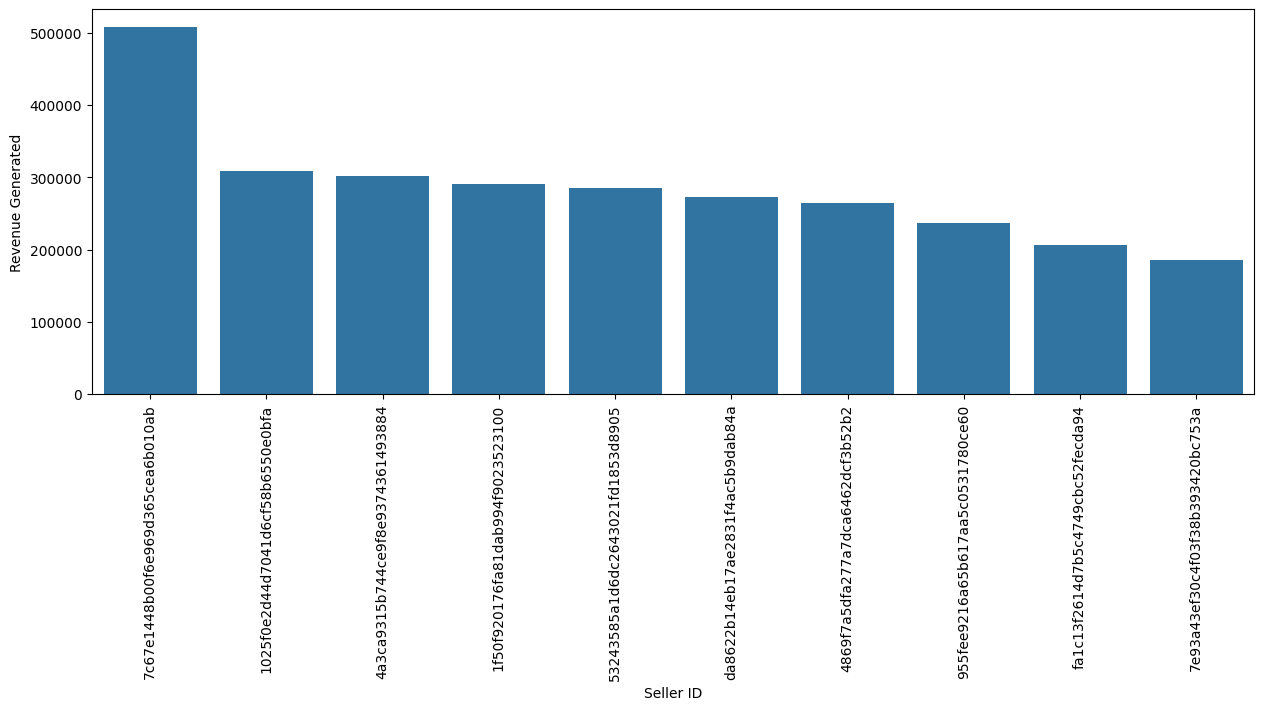

In [77]:
df = df.head(10)
plt.figure(figsize=(15, 5))
sns.barplot(x = 'Seller ID', y = 'Revenue Generated', data = df)
plt.xticks(rotation = 90)
plt.show()


# 11. Calculate the moving average of order values for each customer over their order history.

In [ ]:
#Calculating moving average based on last 2 orders
querry = """ 
select customer_id, order_purchase_timestamp, payment, avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg 
from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from payments join orders 
on payments.order_id = orders.order_id) as a
"""
cursor.execute(querry)
data = cursor.fetchall()
df = pd.DataFrame(data, columns= ['Customer ID','Time Stamp', 'Payments' ,'Moving Average'])
df

,Customer ID,Time Stamp,Payments,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# 12. Calculate the cumulative sales per month for each year.

In [61]:
querry = """ 
SELECT 
    years, 
    months, 
    payment, 
    SUM(payment) OVER (ORDER BY years, month_num) AS cumulative_sales
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years, 
        MONTHNAME(orders.order_purchase_timestamp) AS months,
        MONTH(orders.order_purchase_timestamp) AS month_num,  
        ROUND(SUM(payments.payment_value), 2) AS payment
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years, months, month_num
) AS a
ORDER BY years, month_num
"""
cursor.execute(querry)
data = cursor.fetchall()
df = pd.DataFrame(data, columns= ['Year','Month', 'Payments' ,'Cumulative Sales'])
df

,Year,Month,Payments,Cumulative Sales
0,2016,September,252.24,252.24
1,2016,October,59090.48,59342.72
2,2016,December,19.62,59362.34
3,2017,January,138488.04,197850.38
4,2017,February,291908.01,489758.39
5,2017,March,449863.60,939621.99
6,2017,April,417788.03,1357410.02
7,2017,May,592918.82,1950328.84
8,2017,June,511276.38,2461605.22
9,2017,July,592382.92,3053988.14


# 13. Calculate the year-over-year growth rate of total sales.

In [62]:
querry = """ 
with a as
(SELECT 
	YEAR(orders.order_purchase_timestamp) AS years, 
	ROUND(SUM(payments.payment_value), 2) AS payment
FROM orders 
JOIN payments ON orders.order_id = payments.order_id
GROUP BY years
order by years)
select 
	years,
    payment,
    ((payment - lag(payment, 1) over (order by years))/lag(payment, 1) over (order by years)) *100
from a 
"""
cursor.execute(querry)
data = cursor.fetchall()
df = pd.DataFrame(data, columns= ['Year', 'Total Sales', 'Year over Year growth %'])
df

,Year,Total Sales,Year over Year growth %
0,2016,59362.34,NaN
1,2017,7249746.73,12112.703761
2,2018,8699763.05,20.000924


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [63]:
querry = """ 
with a as (
	select 
		customers.customer_id,
		min(orders.order_purchase_timestamp) as first_order
	from customers join orders
	on customers.customer_id = orders.customer_id
	group by customers.customer_id
),
b as (
	select 
		a.customer_id, 
        count(distinct orders.order_purchase_timestamp)
	from a join orders
	on orders.customer_id = a.customer_id
	and orders.order_purchase_timestamp > first_order
	and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
	group by a.customer_id
)

select 100* (count(distinct a.customer_id)/ count(distinct b.customer_id))
from a left join b 
on a.customer_id = b.customer_id
"""
cursor.execute(querry)
data = cursor.fetchall()
data



[(None,)]

There were no customers who made a second purchase within 6 months on first purchase

# 15. Identify the top 3 customers who spent the most money in each year.

In [64]:
querry = """ 
select 
	years, 
	customer_id, 
    round(payment,2), 
    ranking 
from
(select 
	year(orders.order_purchase_timestamp) as years ,
    orders.customer_id,
    sum(payments.payment_value) as payment,
    dense_rank() over (partition by year(orders.order_purchase_timestamp)
	order by sum(payments.payment_value) desc) ranking
from orders join payments
on orders.order_id = payments.order_id
group by years, orders.customer_id
) as a
where ranking <= 3
"""
cursor.execute(querry)
data = cursor.fetchall()
df = pd.DataFrame(data, columns= ['Year', 'Customer ID', 'Payment', 'Rank'])
df

,Year,Customer ID,Payment,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2
2,2016,4a06381959b6670756de02e07b83815f,1227.78,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.08,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.31,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.88,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.21,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,3


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'a9dc96b027d1252bbac0a9b72d837fc6'),
  Text(1, 0, '1d34ed25963d5aae4cf3d7f3a4cda173'),
  Text(2, 0, '4a06381959b6670756de02e07b83815f'),
  Text(3, 0, '1617b1357756262bfa56ab541c47bc16'),
  Text(4, 0, 'c6e2731c5b391845f6800c97401a43a9'),
  Text(5, 0, '3fd6777bbce08a352fddd04e4a7cc8f6'),
  Text(6, 0, 'ec5b2ba62e574342386871631fafd3fc'),
  Text(7, 0, 'f48d464a0baaea338cb25f816991ab1f'),
  Text(8, 0, 'e0a2412720e9ea4f26c1ac985f6a7358')])

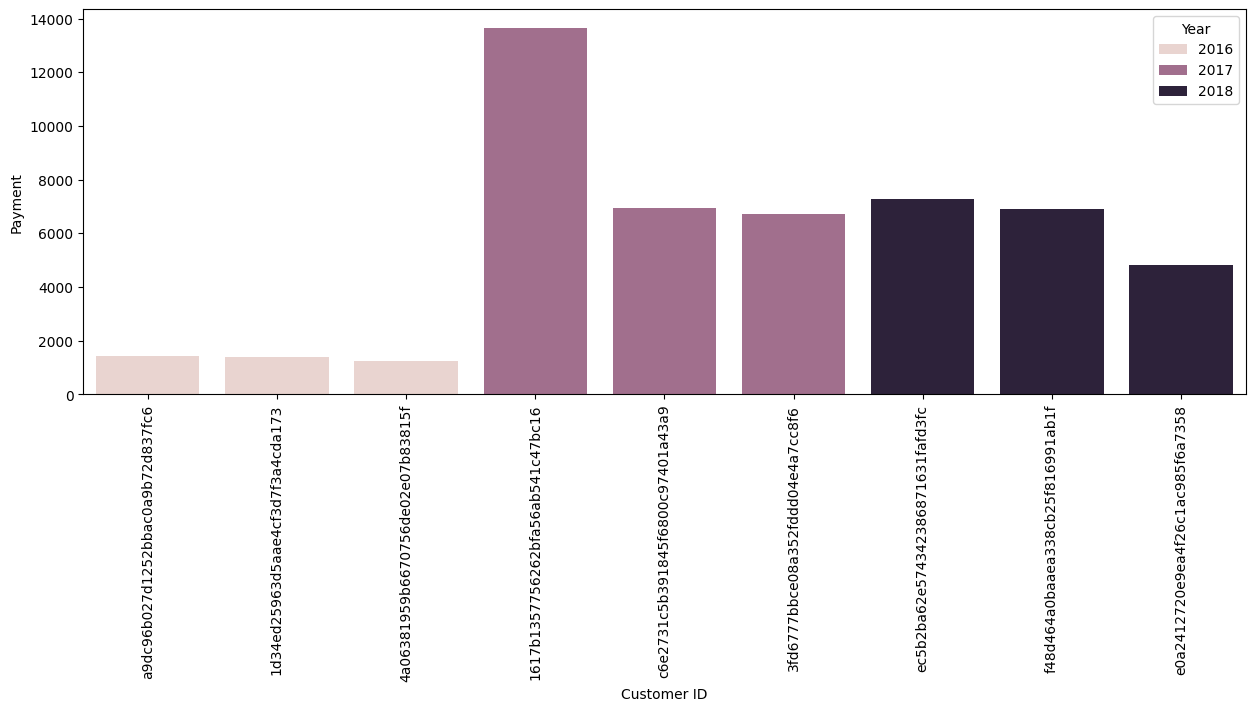

In [74]:
plt.figure(figsize=(15, 5))
sns.barplot(x = 'Customer ID', y = 'Payment', data = df, hue = 'Year')
plt.xticks(rotation = 90)
